In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import category_encoders as ce


0- reading the data

In [ ]:
aisles = pd.read_csv(r"archive\aisles.csv")
department = pd.read_csv(r"archive\departments.csv")
pro_prior = pd.read_csv(r"archive\order_products__prior.csv")
pro_train = pd.read_csv(r"archive/order_products__train.csv")
orders = pd.read_csv(r"archive\orders.csv")
products = pd.read_csv(r"archive\products.csv")

1- Joins and memory optimization

In [5]:
def reduce_memory(df):

    for col in df.columns:
        col_type = df[col].dtype

        if "int" in str(col_type):
            df[col] = df[col].astype("int32")

        elif "float" in str(col_type):
            df[col] = df[col].astype("float32")

        #بالبدايه حطيت بس else بعدين اكتشفت انه في انواع بيانات ثانيه مثل bool
        elif col_type == "object":
            df[col] = df[col].astype("category")

    return df

In [6]:
#حذفتهم لانهم ماخذين حجم كبير وبجميع الاحوال ما رح استخدمهم
# del aisles["aisle"]
# del department["department"]

dfs = [aisles , department , pro_prior , pro_train , orders , products]

for i in range(len(dfs)):
    dfs[i] = reduce_memory(dfs[i])

In [7]:
#   في m1 
#   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
#   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
m1 = pd.merge(pro_prior , orders , on = "order_id" , how = "left")
m2 = pd.merge(m1 , products , on = "product_id" , how = "left")
m3 = pd.merge(m2 , department , on = "department_id" , how = "left")
Full_DataSet = pd.merge(m3 , aisles , on = "aisle_id" , how = "left")

In [8]:
print(Full_DataSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int32   
 3   reordered               int32   
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int32   
 7   order_dow               int32   
 8   order_hour_of_day       int32   
 9   days_since_prior_order  float32 
 10  product_name            category
 11  aisle_id                int32   
 12  department_id           int32   
 13  department              category
 14  aisle                   category
dtypes: category(4), float32(1), int32(10)
memory usage: 1.6 GB
None


In [ ]:
#كنت بدي اصير اعمل قراءه للملف مره ثانيه عشان ما اضل اعمل دمج كل ما اشغل الكود , بس اكتشفت انه تحميله بقعد وقت اكثر
#Full_DataSet.to_csv('archive/full_instacart_data.csv', index=False)

In [ ]:
print("ayham starting eda")

First EDA


days_since_prior_order    2078068
dtype: int64


<Axes: title={'center': 'Missing Values (First Orders vs Reorders)'}, xlabel='days_since_prior_order'>

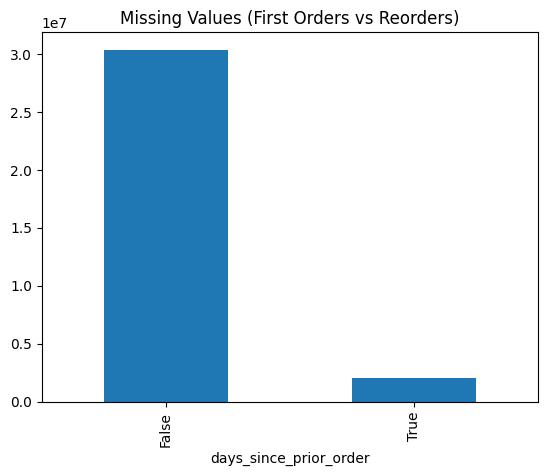

In [14]:
#Checking for missing values in numerical columns

nan_values = Full_DataSet.isnull().sum()
print(nan_values[nan_values > 0])  # هاض عشان نشوف وين العواميد الي فيها مسنق اي عامود فوق ال 0 فهو فيه مسنق

Full_DataSet['days_since_prior_order'].isnull().value_counts().plot(kind='bar', title='Missing Values (First Orders vs Reorders)')

#first orders (True) هاض يعني النان فاليوز لانو اذا طلب اول مره حيكون نان فاليو 


============================================================================


Distribution plots for numeric features and target(s) (histogram, density).


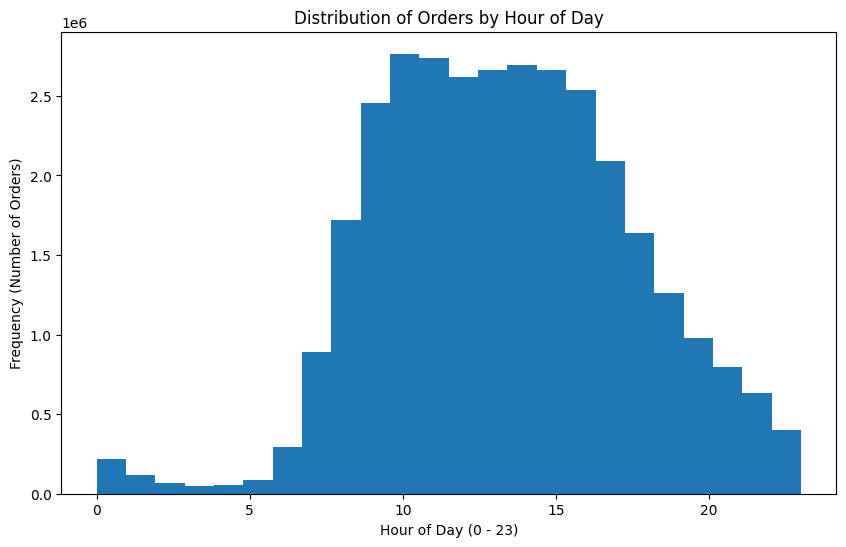

In [23]:
# لازم نختار الاعمده الرقميه الي الها معنى او بتفيدنا لو عملنا الها هستوغرام او دينستي بالاحرى مين مهم افهم الديستربويشن تبعو
Full_DataSet['order_hour_of_day'].plot(kind='hist', bins=24, figsize=(10, 6), title='Distribution of Orders by Hour of Day')

#Histogram (المدرج التكراري) رسمة أعمدة بتبين الكمية في كل فترة

plt.xlabel('Hour of Day (0 - 23)') # سمينا المحور عشان الدكتور يفهم

plt.ylabel('Frequency (Number of Orders)')
plt.show()

بنلاحظ  فوق الوقت الي بكون فيه وقت الذروه للزباين متى بكون باليوم 

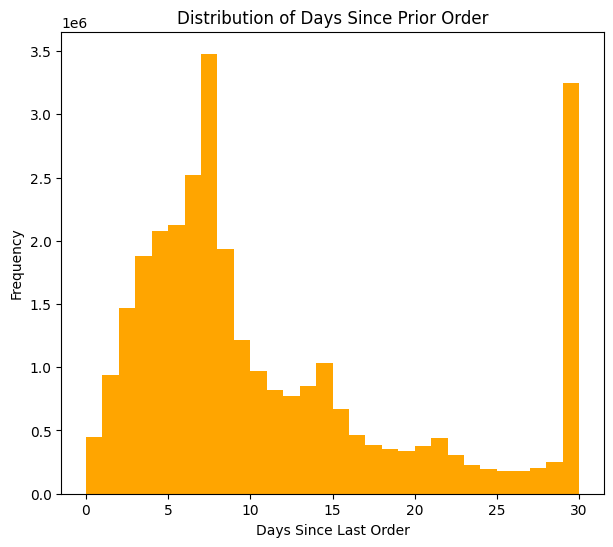

In [25]:
Full_DataSet['days_since_prior_order'].plot(kind='hist', bins=30, figsize=(7, 6), color='orange', title='Distribution of Days Since Prior Order')

plt.xlabel('Days Since Last Order')
plt.ylabel('Frequency')
plt.show()

Weekly shoppers (peak at 7 days) and Monthly shoppers (peak at 30 days). The spike at 30 days also includes customers who haven't ordered for more than a month

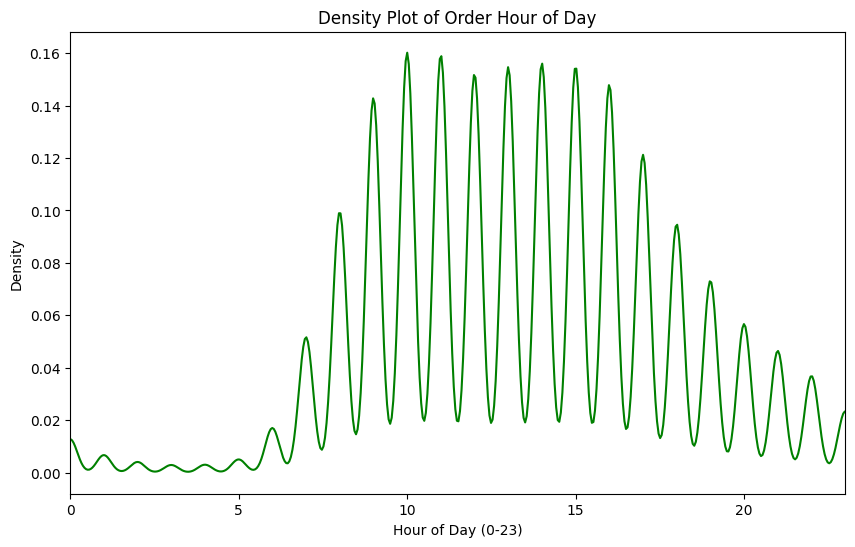

In [26]:
# 1. نأخذ عينة عشوائية (10% مثلاً) عشان الرام ما تنفجر
# هذا العمود يمثل "ساعات اليوم" من 0 لـ 23
sample_hours = Full_DataSet['order_hour_of_day'].sample(frac=0.1, random_state=42)

# 2. الرسم


plt.figure(figsize=(10, 6))

sample_hours.plot(kind='kde', color='green', title='Density Plot of Order Hour of Day')

plt.xlabel('Hour of Day (0-23)')
plt.xlim(0, 23) # عشان نحصر الرسمة في حدود اليوم
plt.show()

الدينستي بعطينا هون تفاصيل اكثر او معبر اكثر بس بوخذ وقت اكثر للامانه 


2- cleaning and preprocessing


In [ ]:
print(Full_DataSet.isnull().sum())
print("---------------------------------------")

#كان هدفي اشوف ال نان من هون بس ما زبطت ف شفتها من الملف نفسه
Full_DataSet.head(10)
#اللي بين معي انه ال نان بكون موجود لكل اول اوردير بطلبه المستخدم\الزبون

In [ ]:
def check_outliers(FD , col):
    print(f"{col}: min:{FD[col].min()} , max:{FD[col].max()} , mean:{FD[col].mean()} , median:{FD[col].median()}")


In [ ]:
#DF = pd.DataFrame(Full_DataSet)

colname = ["order_hour_of_day" , "days_since_prior_order" , "add_to_cart_order"]
for col in colname:
    check_outliers(Full_DataSet , col)
    print("\n")


print(Full_DataSet["add_to_cart_order"].value_counts().sort_index())
print()
#اي تكرار تحت ال10 رح اعتبرهم اوتلاير واشيلهم 
#Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 110 , 109 , Full_DataSet["add_to_cart_order"])

col = "add_to_cart_order"
x = Full_DataSet[col].dropna()

q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers = x[(x < lower) | (x > upper)]
print(f"n={len(x)}  outliers={len(outliers)}  IQR-range=[{lower:.1f}, {upper:.1f}]")

plt.figure(figsize=(12, 4))
sns.histplot(x, bins=50, kde=True, color="#FFA07A")
plt.title("Histogram + KDE of add_to_cart_order")
plt.xlabel("add_to_cart_order")
plt.tight_layout()
plt.show()


In [ ]:
Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 40 , 40 , Full_DataSet["add_to_cart_order"])
print(Full_DataSet["add_to_cart_order"].describe())
print()

col = "add_to_cart_order"
x = Full_DataSet[col].dropna()

q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers = x[(x < lower) | (x > upper)]
print(f"n={len(x)}  outliers={len(outliers)}  IQR-range=[{lower:.1f}, {upper:.1f}]")

plt.figure(figsize=(12, 4))
sns.histplot(x, bins=50, kde=True, color="#FFA07A")
plt.title("Histogram + KDE of add_to_cart_order")
plt.xlabel("add_to_cart_order")
plt.tight_layout()
plt.show()

In [ ]:
Full_DataSet.dtypes

In [ ]:
imputer = SimpleImputer(strategy = "constant" , fill_value = 0)

Full_DataSet["days_since_prior_order"] = imputer.fit_transform(Full_DataSet["days_since_prior_order"].values.reshape(-1,1))

DF = pd.DataFrame(Full_DataSet , columns = Full_DataSet.columns)

#DF.to_csv('archive/full_instacart_data.csv', index=False)
DF.head()



In [ ]:
product_counts = DF['product_name'].value_counts()
product_counts.head(20)

In [ ]:

numeric_cols = ["order_hour_of_day" , "days_since_prior_order" , "add_to_cart_order" , "order_number"]
low_cols = ["department_id" , "aisle_id" , "order_dow" , "eval_set"]
high_cols = ["user_id" , "product_id"]
target_cols = ["product_name"]

ONE = OneHotEncoder(handle_unknown='ignore' , sparse_output = False)
TE = ce.TargetEncoder(cols=high_cols , min_samples_leaf=100 , smoothing=10)
DF['product_freq'] = DF['product_name'].map(product_counts)

#تعلم كيف تعمل k fold cross validation مع target encoding
#ارجع تأكد من جزئية الاوتلايرز حاسها غلط او فيها نقص

